# Klasyfikacja obrazów za pomocą głębokich sieci neuronowych

In [28]:
import os

# Ustawienie PyTorch jako zaplecza dla biblioteki Keras
os.environ["KERAS_BACKEND"] = "torch"

# PyTorch i keras
import torch
import keras
from keras import datasets, layers, models
from keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt

set_global_policy('mixed_float16')
# Sprawdzenie dostępności GPU
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    if torch.xpu.is_available():
        for i in range(torch.xpu.device_count()):
            print(f"XPU {i}: {torch.xpu.get_device_name(i)}")
    else:
        print("Brak dostępnych GPU lub XPU.")
        print("Używam CPU.")

GPU 0: Tesla T4


### Przygotowanie zestawu danych CIFAR10
Przykłady w tym zbiorze mają format 32 na 32 punkty i są kolorowe, a więc posiadają try kanały.

In [29]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Weryfikacja przykładów

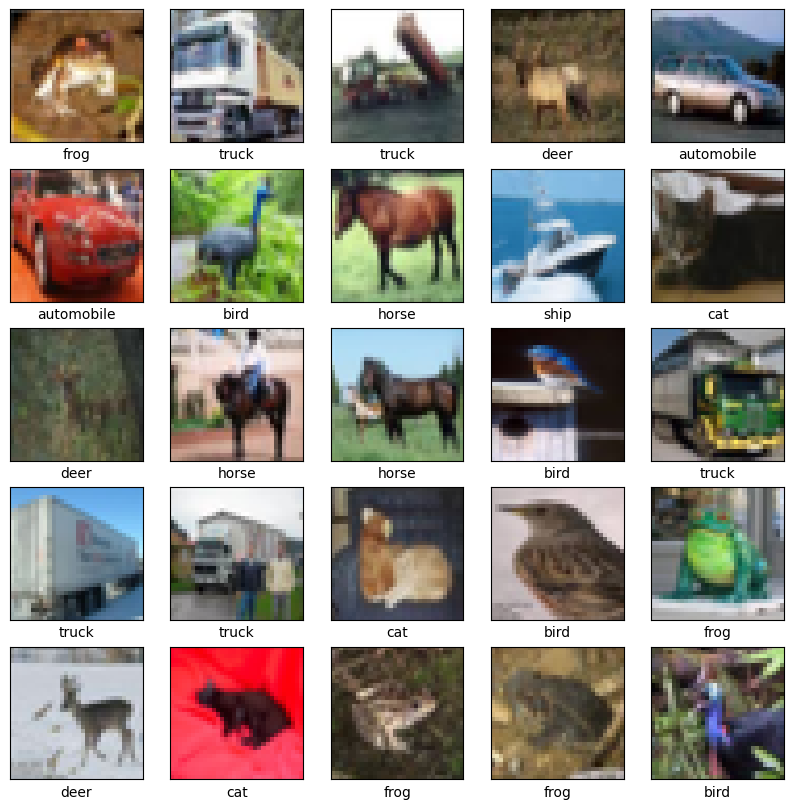

In [30]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Głowa klasyfikatora

In [31]:
def classifier_head(classifier = keras.Sequential([]), classifier_input = ()):
    classifier.add(layers.Flatten(input_shape=classifier_input))
    classifier.add(layers.Dense(
        1024,
        activation='relu'))
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(
        1024,
        activation='relu'))
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(10))
    return classifier

### AlexNet

In [57]:
def alexnet(classifier_input):
    alexnet = keras.Sequential([])

    alexnet.add(keras.Input(shape=classifier_input))
    alexnet.add(layers.Resizing(224, 224))

    #stem (data ingest)
    alexnet.add(layers.Conv2D(64,
                            (11, 11),
                              activation='relu',
                              strides=4
                             ))
    alexnet.add(layers.MaxPool2D(pool_size=3, strides=2))
    alexnet.add(layers.BatchNormalization())

    #body (data processing)
    alexnet.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    alexnet.add(layers.MaxPool2D(pool_size=3, strides=2))
    alexnet.add(layers.BatchNormalization())

    alexnet.add(layers.Conv2D(192, (3, 3), padding='same', activation='relu'))
    alexnet.add(layers.BatchNormalization())

    alexnet.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    alexnet.add(layers.BatchNormalization())
    alexnet.add(layers.MaxPool2D(pool_size=3, strides=2))

    classifier_head(alexnet)#(prediction)
    return alexnet

In [101]:
def alexnet_smol(classifier_input):
    alexnet = keras.Sequential([])

    alexnet.add(keras.Input(shape=classifier_input))

    #stem (data ingest)
    alexnet.add(layers.Conv2D(128,
                            (5, 5),
                              activation='relu',
                              strides=1
                             ))
    alexnet.add(layers.MaxPool2D(pool_size=3, strides=2))
    alexnet.add(layers.BatchNormalization())

    #body (data processing)
    alexnet.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    alexnet.add(layers.MaxPool2D(pool_size=2, strides=2))
    #alexnet.add(layers.BatchNormalization())

    alexnet.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    #alexnet.add(layers.BatchNormalization())

    alexnet.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    #alexnet.add(layers.BatchNormalization())

    alexnet.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    #alexnet.add(layers.BatchNormalization())
    alexnet.add(layers.MaxPool2D(pool_size=2, strides=2))

    classifier_head(alexnet)#(prediction)
    return alexnet

### Grupy wizualnych geometri (VGG)

In [143]:
def vgg_block(num_convs, num_channels):
    block = models.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(num_channels, kernel_size=3, padding='same', activation='relu'))

    block.add(layers.MaxPool2D(pool_size=2, strides=2))
    return block

def vgg11(classifier_input, arch=(
    (1, 64), (1, 128),
    (2, 256), (2, 512), (2, 512))):
    net = keras.Sequential([keras.Input(shape=classifier_input),
                               layers.Resizing(224, 224)
                               ])
    for (num_convs, num_channels) in arch:
        net.add(vgg_block(num_convs, num_channels))
    classifier_head(net)
    return net

def vgg16(classifier_input,
    arch=(
    (2, 64), (2, 128),
    (3, 256), (3, 512), (3, 512)),
    shrink = False):
    net = keras.Sequential([keras.Input(shape=classifier_input),
                               layers.Resizing(224, 224)
                               ])
    for (num_convs, num_channels) in arch:
        net.add(vgg_block(num_convs, num_channels if not shrink else num_channels//4))
    classifier_head(net)
    return net

def vgg19(classifier_input, arch=(
    (2, 64), (2, 128),
    (4, 256), (4, 512), (4, 512))):
    net = keras.Sequential([keras.Input(shape=classifier_input),
                               layers.Resizing(224, 224)
                               ])
    for (num_convs, num_channels) in arch:
        net.add(vgg_block(num_convs, num_channels))
    classifier_head(net)
    return net


### Sieć w sieci (NiN)

In [7]:
def nin_block(out_channels, kernel_size, strides, padding):
    return models.Sequential([
    layers.Conv2D(out_channels, kernel_size, strides=strides, padding=padding),
    layers.Activation('relu'),
    layers.Conv2D(out_channels, 1),
    layers.Activation('relu'),
    layers.Conv2D(out_channels, 1),
    layers.Activation('relu')])

def nin(classifier_input):
    return models.Sequential([
        keras.Input(shape=classifier_input),
        layers.Resizing(224, 224),
        nin_block(96,
                  kernel_size=11,
                  strides=4,
                  padding='valid'),
        layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        layers.MaxPool2D(pool_size=3, strides=2),
        layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        layers.GlobalAvgPool2D(),
        layers.Flatten()])

### Wybór modelu

In [121]:
model1 = alexnet_smol(classifier_input=(32,32,3))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_141 (Conv2D)             │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 13, 13, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,347,466 (28.03 MB)

 Trainable params: 7,347,210 (28.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [122]:
#model = vgg11(classifier_input=(32,32,3), arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))
model2 = alexnet_smol(classifier_input=(32,32,3))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_146 (Conv2D)             │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 13, 13, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 13, 13, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 6, 6, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,347,466 (28.03 MB)

 Trainable params: 7,347,210 (28.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [131]:
model3 = alexnet_smol(classifier_input=(32,32,3))
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_156 (Conv2D)             │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 13, 13, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 13, 13, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 6, 6, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,347,466 (28.03 MB)

 Trainable params: 7,347,210 (28.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [144]:
model4 = vgg16(classifier_input=(32,32,3), shrink=True)
model4.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_21 (Resizing)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_54 (Sequential)      │ (None, 112, 112, 16)   │         2,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_55 (Sequential)      │ (None, 56, 56, 32)     │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_56 (Sequential)      │ (None, 28, 28, 64)     │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_57 (Sequential)      │ (None, 14, 14, 128)    │       369,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_58 (Sequential)      │ (None, 7, 7, 128)      │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1024)           │     6,423,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,404,186 (32.06 MB)

 Trainable params: 8,404,186 (32.06 MB)

 Non-trainable params: 0 (0.00 B)

### Skład i trening modelu

In [145]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model1.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    batch_size=64
                    )

Epoch 1/10
 81/782 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9685 - loss: 0.0923

KeyboardInterrupt: 

In [126]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    batch_size=64
                    )

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.3334 - loss: 1.7732 - val_accuracy: 0.4799 - val_loss: 1.4330
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.6110 - loss: 1.1044 - val_accuracy: 0.6473 - val_loss: 1.0458
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.6952 - loss: 0.8711 - val_accuracy: 0.6368 - val_loss: 1.0695
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7542 - loss: 0.6989 - val_accuracy: 0.7144 - val_loss: 0.8457
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8029 - loss: 0.5731 - val_accuracy: 0.7446 - val_loss: 0.7644
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8391 - loss: 0.4633 - val_accuracy: 0.7019 - val_loss: 1.0680
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8736 - loss: 0.3691 - val_accuracy: 0.7537 - val_loss: 0.8585
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9054 - loss: 0.2785 - 

In [132]:
model3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = model3.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    batch_size=512
                    )

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.2568 - loss: 1.9886 - val_accuracy: 0.3035 - val_loss: 2.1955
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4968 - loss: 1.3776 - val_accuracy: 0.5193 - val_loss: 1.9915
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.5991 - loss: 1.1313 - val_accuracy: 0.5834 - val_loss: 1.7008
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6528 - loss: 0.9822 - val_accuracy: 0.6384 - val_loss: 1.3770
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6927 - loss: 0.8761 - val_accuracy: 0.6835 - val_loss: 1.0727
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7396 - loss: 0.7585 - val_accuracy: 0.6770 - val_loss: 0.9258
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7539 - loss: 0.7036 - val_accuracy: 0.7409 - val_loss: 0.7554
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7806 - loss: 0.6313 - val_accuracy: 0.7542 - 

In [ ]:
model4.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history4 = model4.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    batch_size=128
                    )

Epoch 1/10
138/391 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.3784 - loss: 1.7031

### Ocena modelu

313/313 - 3s - 10ms/step - accuracy: 0.7871 - loss: 0.9401


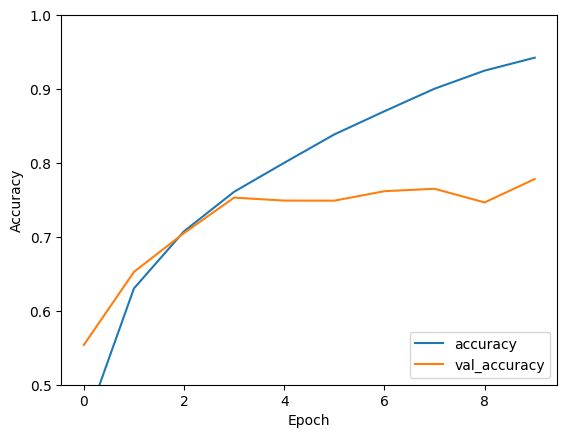

In [127]:
history = history1 #AlexNet modified
model = model1
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - 10ms/step - accuracy: 0.7982 - loss: 0.7819


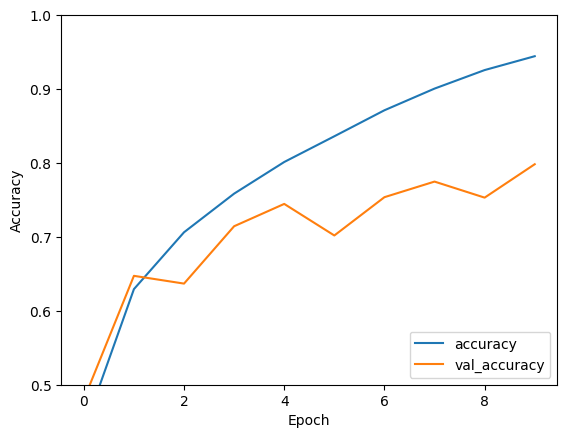

In [129]:
history = history2 # AlexNet32
model = model2
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - 10ms/step - accuracy: 0.7705 - loss: 0.7040


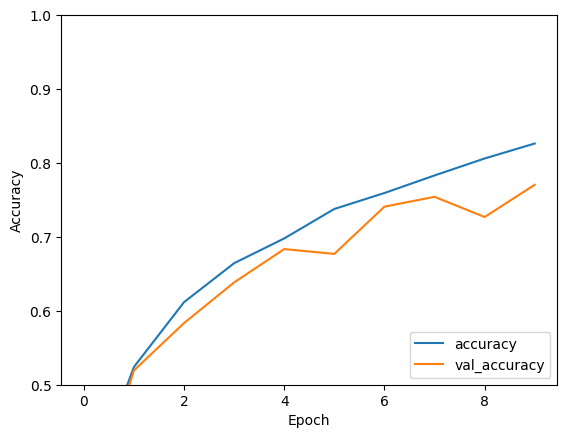

In [133]:
history = history3 # AlexNet32 new batch size
model = model3
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [114]:
print(test_acc)

0.766700029373169


## Zadania
1. AlexNet może być zbyt złożony jak na zbiór danych CIFAR-10, w szczególności ze względu na niską rozdzielczość obrazów.
    1. Spróbój uprościć model, tak aby możliwie jak najbardziej przyspieszyć uczenie, ale jednocześnie nadal nie pogorszyć trafności. (1 pkt)
    2. Opracuj lepszy model, działający bezpośrednio na obrazach w rozmiarze 32x32. (1 pkt)
2. Sprawdź wpływ parametru `batch_size` na trafność predykcji, przepływność (liczbę przetwarzanych obrazów na sekundę) i zużycie pamięci GPU. Znajdź optymalną wartość (1 pkt)
3. Na podstawie Tabeli 1 w artykule pod adresem https://arxiv.org/abs/1409.1556, zbuduj inne popularny model, takie jak VGG-16 lub VGG-19. (1 pkt.)
4. Zmodyfikuj sieć VGG tak, aby przyjmowała mniejsze obrazy na przykład o rozmiarze 64x64 lub 96x96. Zadbaj o to, aby zachować trafność predykcji. W tym celu możesz wykozystać sposoby na dodanie dodatkowych nieliniowości opisane w artykule z poprzedniego zadania. (1 pkt)